In [129]:
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    validation_curve,
    train_test_split,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    log_loss,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [130]:
np.random.seed(42)

In [131]:
# Grab extracted features and labels (TRAIN SET).
with h5.File('features_train.h5', 'r') as file:
    X_train, y_train = file['images'][:], file['labels'][:]
    classes = file['classes'][:]

### Logistic Regression

In [132]:
# Params used to find the best estimator.
params = {
    'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0, 1000.0],
    'max_iter': [1, 10, 50, 100, 1000]
}

model = GridSearchCV(
    LogisticRegression(
        solver='lbfgs',
        multi_class='auto'
    ),
    param_grid=params,
    cv=3,
    n_jobs=-1, # -1: all cores
    verbose=2,
)

In [133]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0,
                               1000.0],
                         'max_iter': [1, 10, 50, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [134]:
print('Best estimator is', model.best_estimator_)
print('Best score is', model.best_score_)

Best estimator is LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score is 0.9056224899598394


### Train the best model

In [135]:
best_model = model.best_estimator_

best_model.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross-Validation Score

In [136]:
cvscore = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

In [137]:
f'Cross Validation Score is ~{round(np.average(cvscore), 3) * 100}%.'

'Cross Validation Score is ~91.0%.'

### Confusion matrix

In [138]:
y_train_preds = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
)

In [139]:
confusion_matrix(y_train, y_train_preds)

array([[221,  28],
       [ 17, 232]])

### Precision

In [140]:
precision_score(y_train, y_train_preds)

0.8923076923076924

### Recall

In [141]:
recall_score(y_train, y_train_preds)

0.9317269076305221

### F1-Score (harmonic mean)

In [142]:
f1_score(y_train, y_train_preds)

0.9115913555992142

### Precision recall curve

In [143]:
y_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1,
)

In [144]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

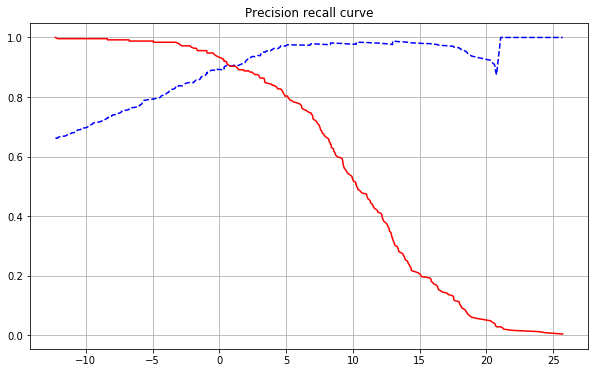

In [145]:
plt.figure(figsize=(10, 6))
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.grid()
plt.show()

### ROC Curve

In [146]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

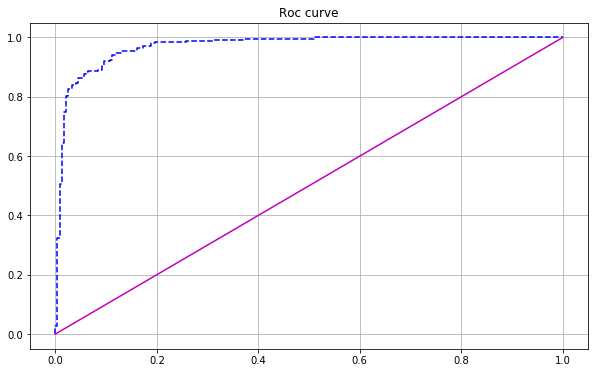

In [147]:
plt.figure(figsize=(10, 6))
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b--')
plt.plot([0, 1], [0, 1], 'm-')
plt.grid()
plt.show()

### ROC-AUC Score

In [148]:
roc_auc_score(y_train, y_scores)

0.9714843308978888

### Learning curve

In [149]:
lrn_curve = learning_curve(
    best_model,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
)

In [150]:
train_sizes_abs, train_scores, val_scores = lrn_curve

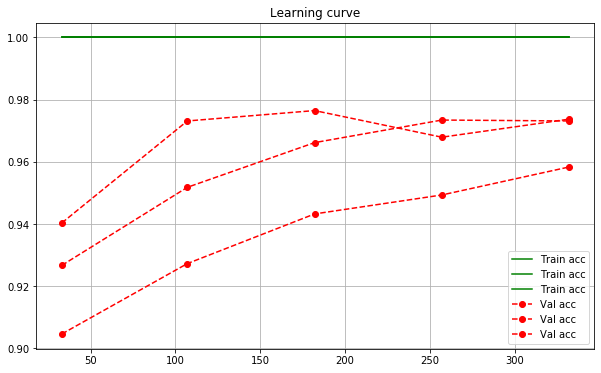

In [151]:
plt.figure(figsize=(10, 6))
plt.title('Learning curve')
plt.plot(train_sizes_abs, train_scores, 'g-', label='Train acc')
plt.plot(train_sizes_abs, val_scores, 'ro--', label='Val acc')
plt.legend(loc='best')
plt.grid()
plt.show()

In [163]:
def plot_learning_curves(model, X, y):
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2)
    train_loss = []
    val_loss = []
    
    for m in np.linspace(2, len(X_train)-2, 20, dtype=int):
        model.fit(X_t[:m], y_t[:m])
        y_train_predict = model.predict(X_t[:m])
        y_val_predict = model.predict(X_v)
        train_loss.append(log_loss(y_t[:m], y_train_predict))
        val_loss.append(log_loss(y_v, y_val_predict))
    
    plt.figure(figsize=(10, 6))
    plt.title('Learning curve')
    plt.plot(train_loss, 'r-+', label='Train Loss')
    plt.plot(val_loss, 'b-', label='Val Loss')
    plt.legend(loc='best')
    plt.show()

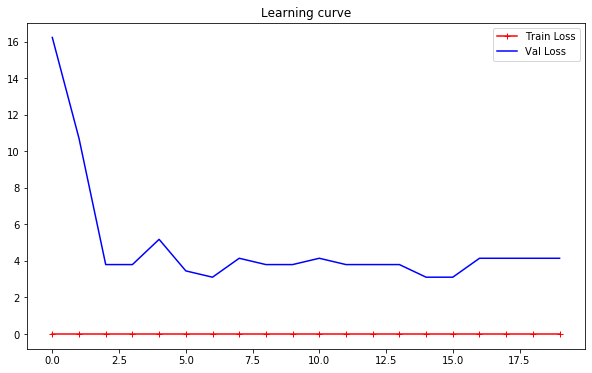

In [164]:
plot_learning_curves(best_model, X_train, y_train)